## Predicting the Winners of European Soccer Matches

Practicing on a somewhat messy relational database and building a multiclass classification model for complex data. Working with the soccer database from kaggle (https://www.kaggle.com/hugomathien/soccer). 

In [1]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings("ignore")

% matplotlib inline

In [2]:
epl = sqlite3.connect('C:/Users/fisol/Desktop/Class Docs/DATA 803/Python II - Johnson/Class 4/HW/soccer_2/database.sqlite')

In [3]:
pd.read_sql_query('select * from sqlite_master where type="table"', epl)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [4]:
match = pd.read_sql_query('select * from Match', epl)
team_attr = pd.read_sql_query('select * from Team_Attributes', epl)
team = pd.read_sql_query('select * from Team', epl)

In [5]:
#Drop unecessary colums

team_attr.drop(['id', 'date'], axis=1, inplace=True)
match.drop([  'date', 'id', 'season', 'home_player_X1',  'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6',  'home_player_X7', 'home_player_X8', 
            'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 
            'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2',
             'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
             'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
             'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
             'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
             'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'goal', 'shoton',
            'shotoff', 'foulcommit',  'country_id', 'league_id', 'stage', 'match_api_id', 'card', 'cross', 'corner', 'possession',  'GBH',  'GBD',  'GBA',  'BSH',  'BSD',  'BSA','PSH', 'SJH',  'SJD',  'SJA', 'PSD', 'PSA'],  axis=1, inplace=True)

In [6]:
#Data cleaning and merging

teams_w_atts = team_attr['team_api_id'].unique()

unique_team_att_idx = []
for tm in teams_w_atts:
    idx = team_attr[team_attr['team_api_id'] == tm].index
    unique_team_att_idx.append(np.random.choice(idx, size=1)[0])
    
team_atts = team_attr.loc[unique_team_att_idx, :]


def change_all_column_names(dataframe=None, add='home_'):
    tmp = dataframe.copy(deep=True)
    cols = list(tmp.columns)
    for i, col in enumerate(cols):
        cols[i] = add+col
    tmp.columns = cols
    return tmp

home_team_atts = change_all_column_names(team_atts, add='home_')
away_team_atts = change_all_column_names(team_atts, add='away_')

match_w_home_atts = match.merge(home_team_atts, on='home_team_api_id', how='left')
master = match_w_home_atts.merge(away_team_atts, on='away_team_api_id', how='left')

In [7]:
#Creating the response column with 3 classes.

def game_results(row):
    if row[0] == row[1]:
        return "Draw"
    elif row[0] > row[1]:
        return "Home Win"
    else:
        return "Away Win"
    
master["results"] = master[['home_team_goal', 'away_team_goal']].apply(game_results, axis=1)

In [8]:
#shuffling the dataset
x_main = shuffle(master, random_state=0)

** Dropping columns from the dataset in preparation for the modeling **

In [9]:
x_main.drop(['home_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass', 'home_buildUpPlayPassingClass',
 'home_buildUpPlayPositioningClass',  'home_chanceCreationPassingClass',  'home_chanceCreationCrossingClass', 
 'home_chanceCreationShootingClass', 'home_chanceCreationPositioningClass',  'home_defencePressureClass',
 'home_defenceAggressionClass',  'home_defenceTeamWidthClass',  'away_buildUpPlayDribbling', 'home_defenceDefenderLineClass',
 'away_buildUpPlaySpeedClass',  'home_buildUpPlayDribbling', 'away_buildUpPlayDribblingClass',  'away_buildUpPlayPassingClass', 
 'away_buildUpPlayPositioningClass',   'away_chanceCreationPassingClass',  'away_chanceCreationCrossingClass', 
 'away_chanceCreationShootingClass',  'away_chanceCreationPositioningClass',  'away_defencePressureClass', 
 'away_defenceAggressionClass',  'away_defenceTeamWidthClass',   'home_team_goal', 'away_team_goal', 'home_team_fifa_api_id',
 'away_team_api_id','away_defenceDefenderLineClass'],  axis=1, inplace=True)

# The Model and Analysis

In [10]:
 # dropping rows with NA's

x_main.dropna(axis=0, how='any', inplace=True) 

In [11]:
x_main.shape

(22156, 37)

In [12]:
#creating my response variable

y = x_main['results']

In [13]:
#creating my predictors 

x_main.drop(['results'], axis=1,  inplace=True)

In [14]:
# #standardizing all the predictors.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_main)

In [15]:
#splitting the data into train and test

Xtr, Xte, ytr, yte = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [16]:
#checking the shape of the train and test split data

print (Xtr.shape, Xte.shape, ytr.shape, yte.shape )

(17724, 36) (4432, 36) (17724,) (4432,)


In [17]:
#creating a list of Cs for the model to pick from.

reg = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [18]:
#Build new model with inbuilt cross validation.

model = LogisticRegressionCV(Cs = reg, solver='lbfgs', multi_class='multinomial')

In [19]:
#train model with the Training Data

model.fit(Xtr, ytr)

LogisticRegressionCV(Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [20]:
#Make predictions on the Training data

model_TRAIN = model.predict(Xtr)

In [21]:
#R-squared score of the model on the Training data

model.score(Xtr,ytr)

0.53300609343263372

In [22]:
#Classification Report of my model on the Training set. High recall on the Home Win predictions

print(classification_report(ytr, model_TRAIN)) 

             precision    recall  f1-score   support

   Away Win       0.53      0.44      0.48      5135
       Draw       0.00      0.00      0.00      4439
   Home Win       0.53      0.88      0.66      8150

avg / total       0.40      0.53      0.45     17724



In [23]:
#My model is predicting mainly Home wins and Away wins but very little draws. 

pd.DataFrame(confusion_matrix(ytr, model_TRAIN))

,0,1,2
0,2261,0,2874
1,1035,0,3404
2,964,0,7186


In [24]:
#Crossvalidate model with 5 folds

model_TRAIN_crossval = cross_val_score(model, Xtr, ytr, scoring='accuracy',n_jobs=-1, verbose=1, cv = 5)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


In [25]:
#The training data is very balanced as the range of scores from the cross validation are minimal.

print(model_TRAIN_crossval )
print(np.mean(model_TRAIN_crossval ))

[ 0.53173484  0.52976023  0.52637518  0.53314528  0.54006772]
0.53221664698


In [26]:
actpred= pd.DataFrame(confusion_matrix(ytr, model_TRAIN))

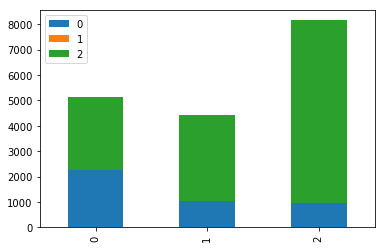

In [27]:
#Creating basic graphic representation of the confusion matrix. We clearly see that the model is heavily predicting Home Wins and Away wins on the training data

actpred.plot(kind='bar',  stacked=True)

**Running The Model on the Test Data**<br>
I am now going to use the trained model to predit on the test data and see how well it performs.

In [28]:
#predicting on the test data 

model_TEST = model.predict(Xte)

In [29]:
#R-squared score on Test data is slightly below that on the train data which is expected since the model has not seen the test data before.

model.score(Xte,yte)

0.51759927797833938

In [30]:
#We see a  reduction in precision on Away Wins here on the test data compared to that on the training but still very high recall on the Home WIns

print(classification_report(yte, model_TEST)) 

             precision    recall  f1-score   support

   Away Win       0.50      0.43      0.46      1245
       Draw       0.00      0.00      0.00      1170
   Home Win       0.52      0.87      0.65      2017

avg / total       0.38      0.52      0.43      4432



In [31]:
#The model fails to make any predictions at all for draws, it only predicts Home and Away wins.

pd.DataFrame(confusion_matrix(yte, model_TEST))

,0,1,2
0,532,0,713
1,280,0,890
2,255,0,1762


In [32]:
#Crossvalidate model on Test Data with 5 folds

model_TEST_crossval = cross_val_score(model, Xte, yte, scoring='accuracy',n_jobs=-1, verbose=1, cv = 5)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


In [33]:
# We also see a consistensy here with the test data as the scores are relatively close to each other

print(model_TEST_crossval )
print(np.mean(model_TEST_crossval ))

[ 0.50394589  0.50732807  0.51805869  0.50677201  0.5248307 ]
0.512187071341


In [34]:
actpred2= pd.DataFrame(confusion_matrix(yte, model_TEST))

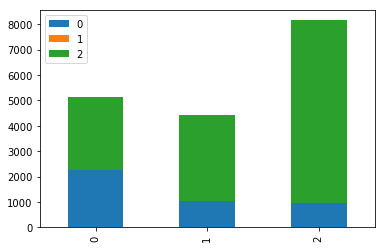

In [35]:
#Plotting the confusion matrix - weak predictions for draws.

actpred.plot(kind='bar',  stacked=True)

In [38]:
epl.close()